In [1]:
#載入所需套件

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import warnings

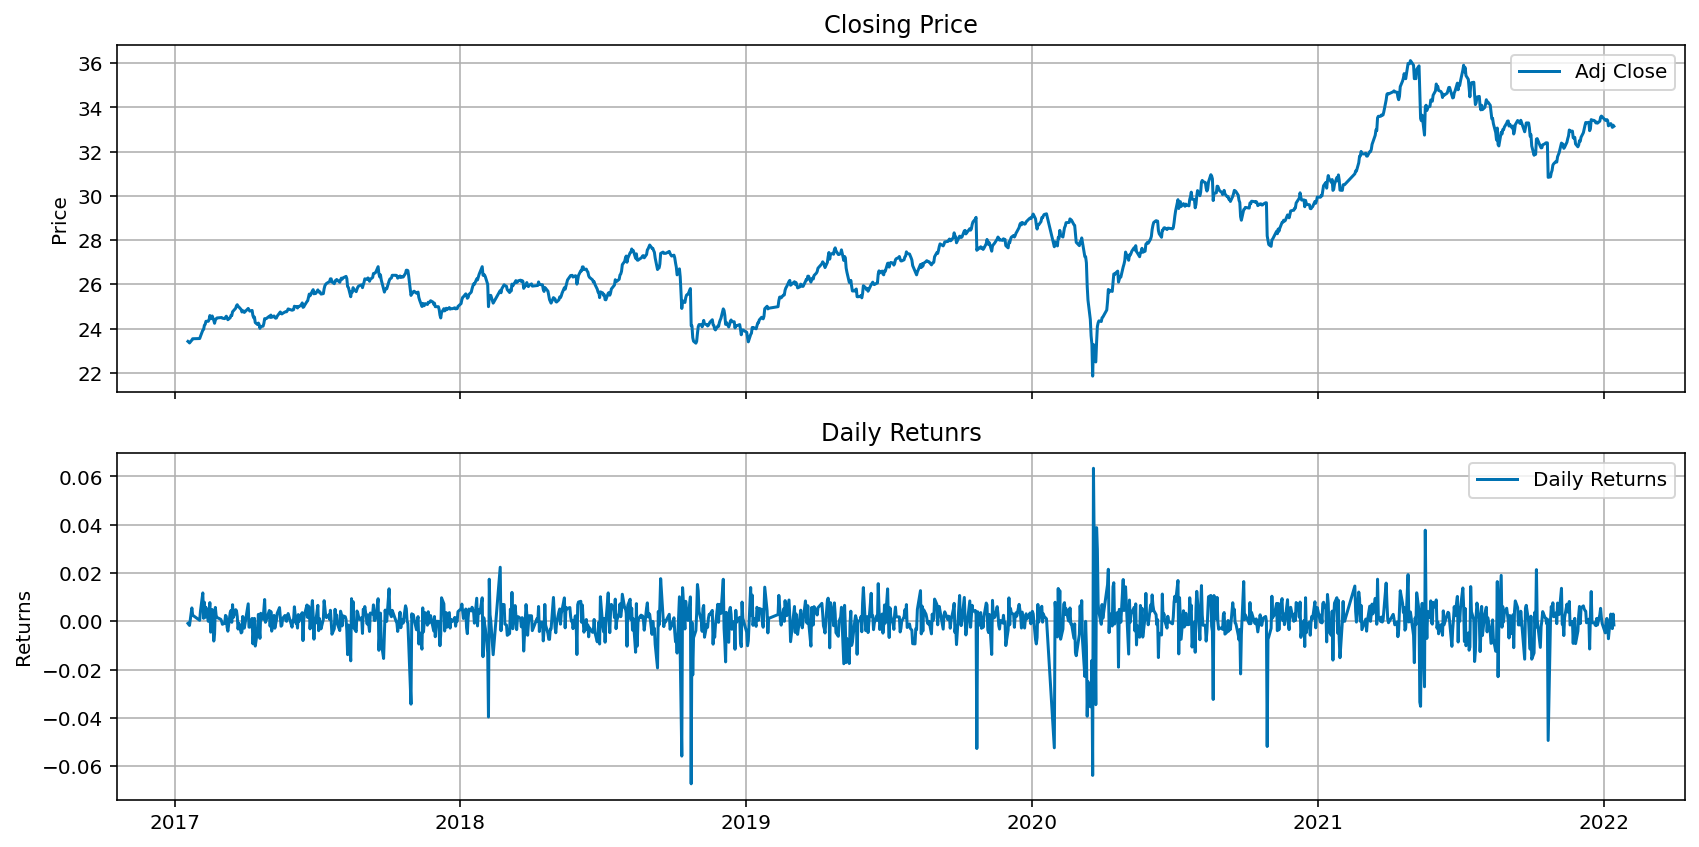

In [2]:
# 設定繪圖的形式
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# 讓圖表直接在Jupyter notebook中顯示
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#從Yahoo finance下載股價資料，載入過去五年0056每日收盤資料
data = pd.read_csv(r'C:\Users\npc94\OneDrive\桌面\0056.TW.csv',index_col=0,parse_dates=True)
stock = pd.DataFrame(data['Close'])


# 計算對數報酬
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)

# 將收盤價和每日報酬一起進行比較
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock['Close'], label = 'Adj Close')
ax[0].set(title= 'Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title =  'Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)

plt.legend()
plt.tight_layout()

In [3]:
# 決定落後的期數
lags = [1, 2, 3, 4, 5]
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
    
stock.dropna(inplace=True)
stock.head(2)

# 將落後期的報酬轉換為二元對立值(0,1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)
        
create_bins(stock)
stock[cols+cols_bin].head(2)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,
2017-02-02,0.002552,0.005552,-0.001712,-0.001282,-0.000854,1,1,0,0,0
2017-02-03,0.000425,0.002552,0.005552,-0.001712,-0.001282,1,1,1,0,0


In [4]:
#載入機器學習套件
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation


# 將資料分為訓練組以及測試組
train, test = train_test_split(stock.dropna(), test_size=0.4, shuffle=False)

#定義並打造深度學習功能
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=len(cols)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

# 將訓練資料標準化處理
mu, std = train.mean(), train.std()
train_ = (train - mu) / mu.std()

# 產生模型
model = create_model()

# 將市場走勢分為(1,-1)和(1,0)
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

#%%time
# 開始訓練
r = model.fit(train_[cols], train['direction_'], epochs=50, verbose=False)

# 將測試資料標準化處理
mu, std = test.mean(), test.std()
test_ = (test - mu) / std

# 將市場走勢分為(1,0)
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

# 評估測試組
model.evaluate(test_[cols], test['direction_'])

# 預測走勢並將之依方向分為(1,0)
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

16/16 [==============================] - 0s 704us/step - loss: 0.7329 - accuracy: 0.5082


array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0])


Total Returns:
returns            1.136831
strategy_return    1.418518
dtype: float64

Annual Volatility:
returns            0.164913
strategy_return    0.164570
dtype: float64
Number of trades =  121


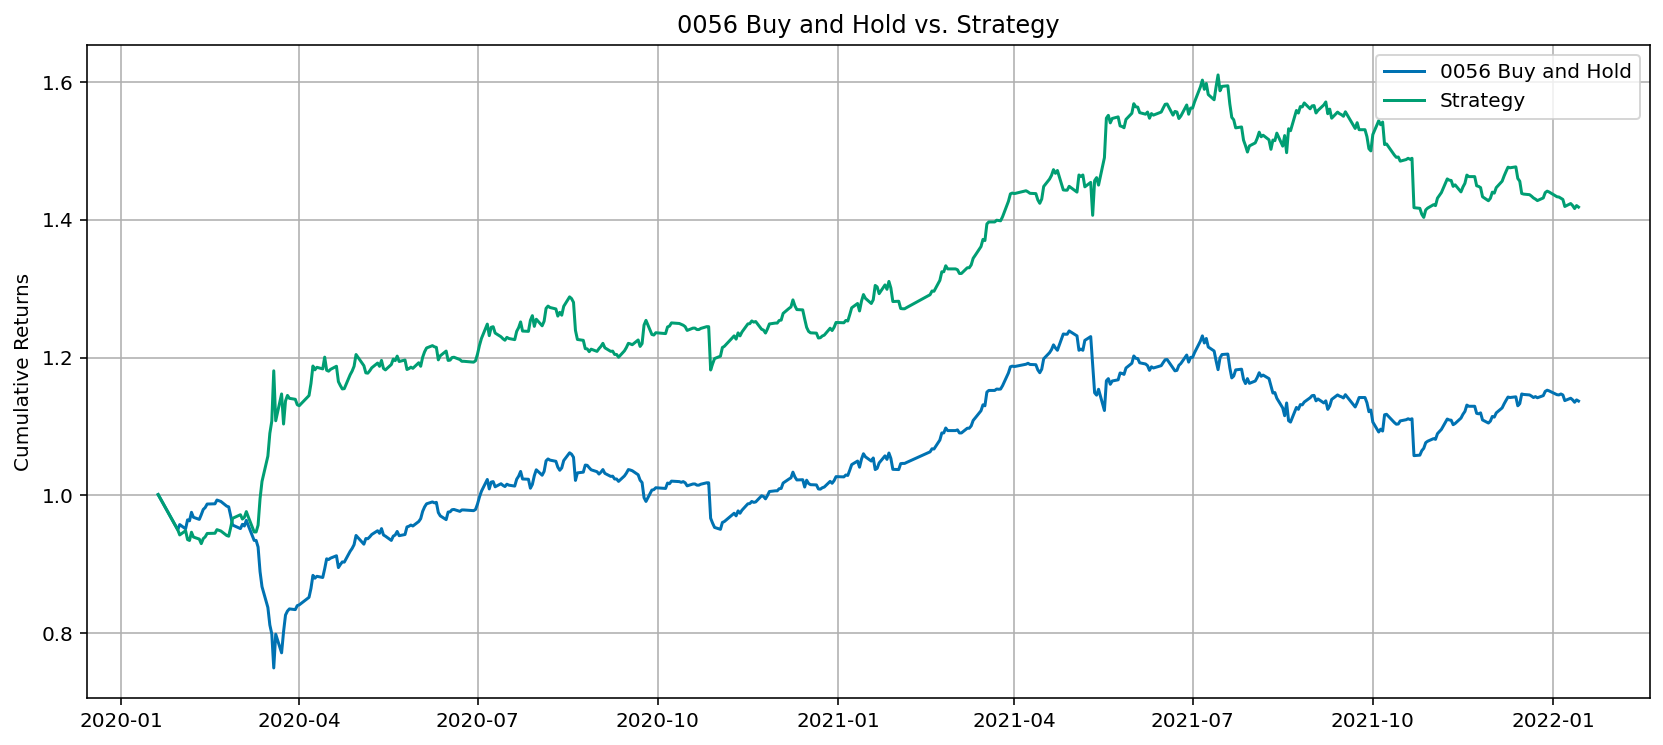

In [5]:
# 根據預測值計算部位變化
test['position_strategy'] = np.where(pred > 0, 1, -1)

# 計算策略的每日報酬
test['strategy_return'] = test['position_strategy'] * test['returns']

# 計算策略的報酬以及風險值
print('\nTotal Returns:')
print(test[['returns', 'strategy_return']].sum().apply(np.exp))
print('\nAnnual Volatility:')
print(test[['returns', 'strategy_return']].std() * 252 ** 0.5)

# 計算策略交易的次數
print('Number of trades = ', (test['position_strategy'].diff()!=0).sum())

# 繪製累積報酬曲線圖
fig, ax = plt.subplots(1, 1, sharex=True, figsize = (14,6))
ax.plot(test.returns.cumsum().apply(np.exp), label = '0056 Buy and Hold')
ax.plot(test.strategy_return.cumsum().apply(np.exp), label = 'Strategy')
ax.set(title = '0056 Buy and Hold vs. Strategy', ylabel = 'Cumulative Returns')
ax.grid(True)
ax.legend()